<a href="https://colab.research.google.com/github/inefable12/deep_learning_para_quimica/blob/main/Challenge_8_supp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 8

# 0. Requerimientos

In [3]:
!git clone https://github.com/BLarzalere/AI-De-Novo-Molecule-Design.git

Cloning into 'AI-De-Novo-Molecule-Design'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 173 (delta 39), reused 65 (delta 33), pack-reused 100
Receiving objects: 100% (173/173), 30.57 MiB | 27.60 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [1]:
# Install RDKit.
%%capture
!pip install rdkit

In [2]:
#no va
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In [4]:
# Importar core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

In [6]:
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.12.0


In [7]:
# Cargar Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [8]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Fri Jun 16 18:03:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |    387MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

# 1. LSTM

In [9]:
# Crear las funciones para el cargado de datos
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [10]:
!ls

AI-De-Novo-Molecule-Design  sample_data


In [13]:
# Cargar el dataset y separar los datos de train/test
smifile = '/content/AI-De-Novo-Molecule-Design/Data/smiles_cleaned.smi'
data = load_data(smifile)
seed = 777
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
print("Training smiles shape:", full_train.shape)
print("Test smiles shape:", test.shape)
print("Sample training smile: \n", full_train[2])

Training smiles shape: (351278,)
Test smiles shape: (87820,)
Sample training smile: 
 Cc1cc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)ccc1F


In [15]:
data.shape

(439098,)

In [16]:
# create our validation dataset
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", val_set.shape)

Training dataset shape: (316150,)
Validation dataset shape: (35128,)


In [17]:
# load the Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/content/AI-De-Novo-Molecule-Design/Data/char_to_int.json'
d2 = '/content/AI-De-Novo-Molecule-Design/Data/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

In [18]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [19]:
# create our X & y datasets
embed = 101
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Validation input shape:", X_val.shape)
print("Validation output shape:", y_val.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)

Training input shape: (316150, 100, 45)
Training output shape: (316150, 100, 45)
Validation input shape: (35128, 100, 45)
Validation output shape: (35128, 100, 45)
Test input shape: (87820, 100, 45)
Test output shape: (87820, 100, 45)


In [20]:
"".join([int_to_char[str(idx)] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!O=c1ccc(OCCCN2CCN(c3csc4ccccc34)CC2)nn1-c1ccc(Cl)c(Cl)c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [21]:
# define the LSTM Chem model
def lstm_model(X, y):
    # define the encoder layers
    enc_input = Input(shape=(X.shape[1:]))
    _, state_h, state_c = LSTM(256, return_state=True)(enc_input)
    states = Concatenate(axis=-1)([state_h, state_c])
    bottle_neck = Dense(128, activation='relu')(states)

    # define the decoder layers
    state_h_decoded = Dense(256, activation='relu')(bottle_neck)
    state_c_decoded = Dense(256, activation='relu')(bottle_neck)
    encoder_states = [state_h_decoded, state_c_decoded]
    dec_input = Input(shape=(X.shape[1:]))
    dec1 = LSTM(256, return_sequences=True)(dec_input, initial_state=encoder_states)
    output = Dense(y.shape[2], activation='softmax')(dec1)

    model = Model(inputs=[enc_input, dec_input], outputs=output)
    return model

In [22]:
# instantiate our neural network model
model = lstm_model(X_train, y_train)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [23]:
# compile the model
batch_size = 256
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [24]:
# compile the model
batch_size = 256
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [29]:
# define our data sequence generator class
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = np.array(x), np.array(y)

        return [batch_x, batch_x], batch_y

In [30]:
# create object instances of our sequence generator
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

In [25]:
# # create our callbacks
file="/content/AI-De-Novo-Molecule-Design/Data/LSTM_Chem_weights-{epoch:02d}-{acc:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
tb = TensorBoard(log_dir="/drive/My Drive/logs/chem/", histogram_freq=1, write_graph=True, write_images=True)

In [31]:
# fit the model
nb_epochs = 20
validation_steps = len(X_val) // batch_size
history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1,
                              validation_data=validation_generator, validation_steps=validation_steps,
                             use_multiprocessing=False, shuffle=True, callbacks=[])

Epoch 1/20
1234/1234 [==============================] - 73s 50ms/step - loss: 0.7933 - acc: 0.7535 - val_loss: 0.5464 - val_acc: 0.8193
Epoch 2/20
1234/1234 [==============================] - 62s 51ms/step - loss: 0.4974 - acc: 0.8321 - val_loss: 0.4565 - val_acc: 0.8440
Epoch 3/20
1234/1234 [==============================] - 61s 49ms/step - loss: 0.4597 - acc: 0.8433 - val_loss: 0.4472 - val_acc: 0.8459
Epoch 4/20
1234/1234 [==============================] - 62s 50ms/step - loss: 0.4198 - acc: 0.8537 - val_loss: 0.4040 - val_acc: 0.8584
Epoch 5/20
1234/1234 [==============================] - 64s 52ms/step - loss: 0.3915 - acc: 0.8623 - val_loss: 0.3814 - val_acc: 0.8656
Epoch 6/20
1234/1234 [==============================] - 61s 50ms/step - loss: 0.3664 - acc: 0.8710 - val_loss: 0.3486 - val_acc: 0.8768
Epoch 7/20
1234/1234 [==============================] - 64s 52ms/step - loss: 0.3394 - acc: 0.8802 - val_loss: 0.3302 - val_acc: 0.8826
Epoch 8/20
1234/1234 [==========================

# 2. Output

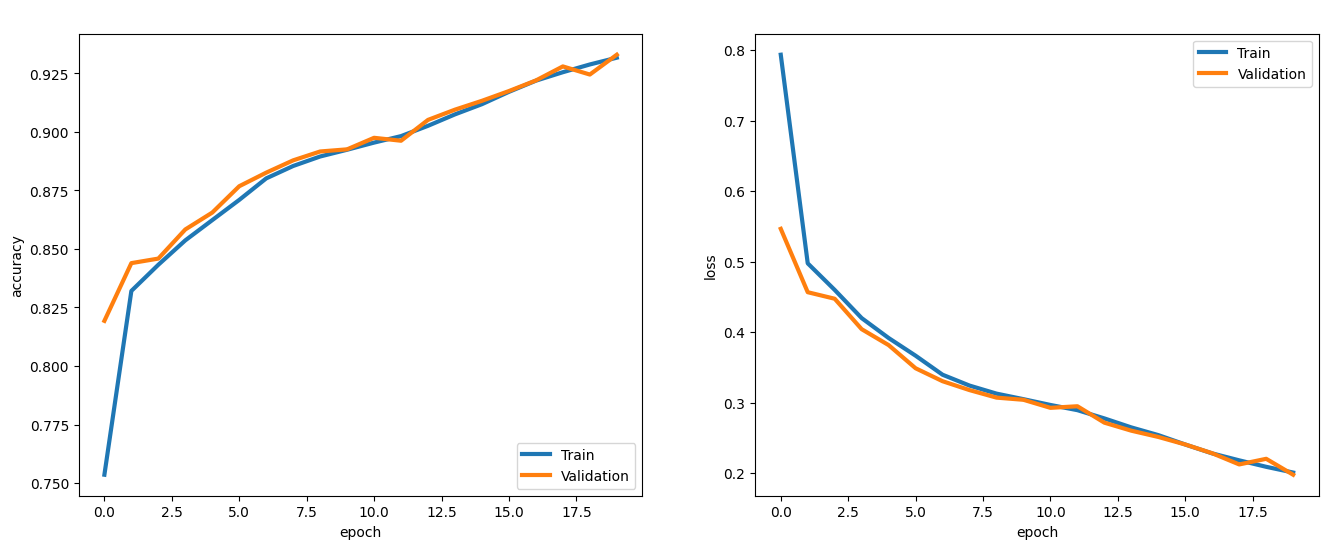

In [32]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16, color="white")
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16, color="white")
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

Nota: Tener en cuenta que solamente se ejecutaron 20 epochs

In [33]:
# evaluate our test set
score, acc = model.evaluate([X_test, X_test], y_test, batch_size=batch_size, verbose=0)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

Test score: 0.19665297865867615
Test accuracy: 0.9334158301353455


In [35]:
# save our baseline training model & weights
mod_file = 'LSTM_model.h5'
model.save(mod_file)
print("Model Saved")

Model Saved


In [36]:
!ls

AI-De-Novo-Molecule-Design  LSTM_model.h5  sample_data
